In [1]:
from sklearn.preprocessing import StandardScaler

from IPython.display import Image
#from sklearn.model_selection import KFold
#from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score

import missingno as msno

from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Binarizer, KBinsDiscretizer

from statsmodels.stats.outliers_influence import variance_inflation_factor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_predict
from patsy import dmatrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score


import xgboost as xgb
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from warnings import filterwarnings
import warnings

%matplotlib inline
%config Inlinebackend.figure_format = 'retina'

# 한글 폰트 설정
mpl.rc('font', family='malgun gothic')

# 시각화 차트에 음수설정
mpl.rc('axes', unicode_minus = False)

# 오류경고
warnings.filterwarnings('ignore')


import seaborn as sns

# 차트 스타일지정     글꼴                    음수처리                        눈금
sns.set(font = 'malgun ghthic', rc={'axes.unicode_minus':False}, style = 'darkgrid')
plt.rc('figure', figsize=(10, 8))


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family = 'malgun gothic')
mpl.rc('axes', unicode_minus=False)

sns.set(font="malgun gothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc('figure', figsize=( 10, 8))

warnings.filterwarnings('ignore')

# User Function

In [3]:
def get_f1(model_name, target, pred) :
    print(model_name, 'Macro f1 socre : ', f1_score(target, pred, average='macro'))
    
def get_f1_score(target, pred) :
    print('Macro f1 socre : ', f1_score(target, pred, average='macro'))
    
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [4]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve, classification_report

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Binarizer


# 평가지표 분류
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도 : {:.4f}, 정밀도 : {:.4f}, 재현율 : {:.4f}, F1 : {:.4f}, AUC : {:.4f}'.
          format(accuracy, precision, recall, f1, roc_auc))

# 재현율과 정밀도의 시각화
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize = (10, 7))
    plt.rc('font', family = 'D2coding')
    threshold_boundary = thresholds.shape[0]
    a = thresholds[precisions[0:threshold_boundary] == recalls[0:threshold_boundary]]
    loc = np.where(thresholds == a[0])[0][0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')
    plt.scatter(thresholds[loc], precisions[loc], c = 'black', s = 60)
    plt.text(0.02 + thresholds[loc], precisions[loc], '임계값 : {:.3f}'.format(thresholds[loc]), size = 15)
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2), size = 15)
    plt.xlabel('Threshold value', size = 15); plt.ylabel('Precision and Recall value', size = 15)
    plt.legend()
    plt.rc('legend', fontsize = 15)
    plt.rc('ytick', labelsize = 15)
    plt.show()
    

# 임계값 조정 함수
def get_clf_eval_thres(y_test, pred_po, threshold, f1_show=False, auc_show=False):
    eval_df = pd.DataFrame()
    
    for thres in threshold:
        # threshold에 따른 예측 분류 값
        binarizer = Binarizer(threshold = thres)
        binarizer.fit(pred_po)
        thres_pred = binarizer.transform(pred_po)
        
        # 평가지표  
        accuracy = accuracy_score(y_test, thres_pred)
        precision = precision_score(y_test, thres_pred)
        recall = recall_score(y_test, thres_pred)
        f1 = f1_score(y_test, thres_pred)
        auc = roc_auc_score(y_test, pred_po)
        
        # 데이터 프레임 형태
        eval_lst = np.array([accuracy, precision, recall, f1, auc]).reshape(-1,1)
        temp = pd.DataFrame(eval_lst, columns=[thres], 
                            index = ["정확도", "정밀도", "재현율", "F1스코어", "AUC"])
        eval_df = pd.concat([eval_df,temp], axis=1)
        
    eval_df.columns.names = ["임계값"]
    
    if f1_show == False:
        eval_df.drop("F1스코어", axis=0, inplace=True)
        
    if auc_show == False:
        eval_df.drop("AUC", axis=0, inplace=True)
        
    return round(eval_df, 4)


def get_acc(data, target) :
    pred_X = grid_clf.predict(data)

    print('train accuracy score :', accuracy_score(target, pred_X))

In [5]:
data = pd.read_csv('C:/k_digital/source/Machine Learning with Python/ML project/oil/train.csv')
test = pd.read_csv('C:/k_digital/source/Machine Learning with Python/ML project/oil/test.csv')

In [6]:
data['FOPTIMETHGLY'].value_counts()

0.0     1954
1.0     1834
2.0       90
3.0        8
13.0       1
7.0        1
5.0        1
10.0       1
Name: FOPTIMETHGLY, dtype: int64

# 데이터 탐색 및 전처리(EDA)

## 데이터 유형 확인

In [7]:
# data.info()

## profiling

In [8]:
#!pip install pandas_profiling

import pandas_profiling
profile_report = pandas_profiling.ProfileReport(data)
profile_report

## 결측치 확인
- U를 2개의 그룹으로 합친 다음에 결측치를 0으로 대체 
- 결측치 0으로 바꾸기

In [9]:
# 비율로 확인 
missing_value = data.isna().sum()
total = data.shape[0]
ratio = round(missing_value/total,2)
print(round(missing_value/total,2))
ratio.sort_values(ascending=False).head(17).index
#  ['U4', 'U6', 'U14', 'U20', 'U50', 'U100', 'U75', 'U25', 'V100', 'FH2O',
#        'FOXID', 'FUEL', 'FOPTIMETHGLY', 'FSO4', 'FTBN', 'SOOTPERCENTAGE',
#        'FNOX'] --> 결측치 70% 이상 

ID                     0.00
COMPONENT_ARBITRARY    0.00
ANONYMOUS_1            0.00
YEAR                   0.00
SAMPLE_TRANSFER_DAY    0.00
ANONYMOUS_2            0.00
AG                     0.00
AL                     0.00
B                      0.00
BA                     0.00
BE                     0.00
CA                     0.00
CD                     0.10
CO                     0.00
CR                     0.00
CU                     0.00
FH2O                   0.72
FNOX                   0.72
FOPTIMETHGLY           0.72
FOXID                  0.72
FSO4                   0.72
FTBN                   0.72
FE                     0.00
FUEL                   0.72
H2O                    0.00
K                      0.16
LI                     0.00
MG                     0.00
MN                     0.00
MO                     0.00
NA                     0.00
NI                     0.00
P                      0.00
PB                     0.00
PQINDEX                0.00
S                   

Index(['U4', 'U6', 'U14', 'U20', 'U50', 'U100', 'U75', 'U25', 'V100', 'FH2O',
       'FOXID', 'FUEL', 'FOPTIMETHGLY', 'FSO4', 'FTBN', 'SOOTPERCENTAGE',
       'FNOX'],
      dtype='object')

In [10]:
data['FOPTIMETHGLY'].value_counts()

0.0     1954
1.0     1834
2.0       90
3.0        8
13.0       1
7.0        1
5.0        1
10.0       1
Name: FOPTIMETHGLY, dtype: int64

In [11]:
# 결측치 시각화 
# plt.figure(figsize=(10,15))
# msno.matrix(data.sample(250))
# plt.show()

In [12]:
# bar
# msno.bar(data)

In [13]:
#한 변수의 유무가 다른 변수의 존재에 얼마나 강하게 영향을 미치는지입니다.
# 결측치가 너무 많아서 "1"로 뜬 것 같다. 
# msno.heatmap(data)

## 결측치 확인 

In [14]:
# 'U20', 'U50', 'U100','U75', 'U25', 'FOPTIMETHGLY','V100' 삭제 
data = data[['ANONYMOUS_1','AL','CA','FE','B','P','S','PQINDEX','V40','MO','ZN','FTBN',
     'SI','CU','ANONYMOUS_2','SAMPLE_TRANSFER_DAY','MG','NA','CR','BA','U4','TI','PB','NI','SN',
     'K','MN','U20','COMPONENT_ARBITRARY', 'YEAR', 'Y_LABEL']]

In [20]:
# 결측치 0으로 채우기
feature = ['K','U4', 'U20']
for i in feature:
    data[i].fillna(0, inplace=True)

In [21]:
# Y_LABEL확인
# data['Y_LABEL'].value_counts()

In [17]:
# 결측치 확인 
# data.isna().sum()

In [19]:
# data['FUEL'].value_counts()

In [22]:
# 결측치 확인 --> 결측치 없음. * FUEL, FTBN은 아직 결측치 존재 . 
# data.isna().sum()

### FTBN

In [23]:
# sns.boxplot(data['FTBN'])
# plt.show()

In [24]:
# data.FTBN.plot()

In [25]:
# 결측치를 뭘로 채우지?
# data['FTBN'].describe()

In [26]:
# data['FTBN'].value_counts()

In [27]:
# data.head(3)

## YEAR, COMPONENT로 groupby 이용해 target값 분석. FUEL

In [28]:
missing_value_mana = [ 'U20',   'FTBN']
for i in missing_value_mana:
    print(i, '\n' ,data[data[i].isna()==True]['Y_LABEL'].value_counts(), '\n-----------------------------')

U20 
 Series([], Name: Y_LABEL, dtype: int64) 
-----------------------------
FTBN 
 0    9314
1     891
Name: Y_LABEL, dtype: int64 
-----------------------------


In [29]:
#pd.options.display.max_rows = 785
# ata.groupby('YEAR')['FTBN'].value_counts()

In [30]:
# data.groupby('YEAR')['Y_LABEL'].value_counts()

In [31]:
# data.groupby('YEAR')['FUEL'].value_counts()

## IterativeImputer

In [32]:
FTBN = pd.DataFrame(data['FTBN'])
# FTBN

In [33]:
FTBN = pd.DataFrame(data['FTBN'])
FTBN
# 결측값을 예측을 통해 채워넣음 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(random_state=100)
FTBN_imputed = imputer.fit_transform(FTBN)

# describe()를 하기위해 dataframe으로 바꿔줌 
FTBN_imputed = pd.DataFrame(FTBN_imputed)
# FTBN_imputed.describe()

In [34]:
FTBN_imputed = pd.DataFrame(FTBN_imputed)
# FTBN_imputed.describe()

In [35]:
# iterative impute 하기 전.
# data['FTBN'].describe()

## 결측치 많은 애들 heatmap

In [36]:
# data.shape

In [37]:
# plt.figure(figsize = (35, 35))
# sns.heatmap(data.corr(), 
#            annot = True, fmt = '0.1f',cmap = 'Blues')

In [38]:
data['FTBN'] = FTBN_imputed

In [39]:
# data

In [40]:
data['U20'] = data['U20'].fillna(0)
data['U20']

0           0.0
1           4.0
2           3.0
3           0.0
4           0.0
          ...  
14090       0.0
14091       0.0
14092       0.0
14093       8.0
14094    2565.0
Name: U20, Length: 14095, dtype: float64

<AxesSubplot:>

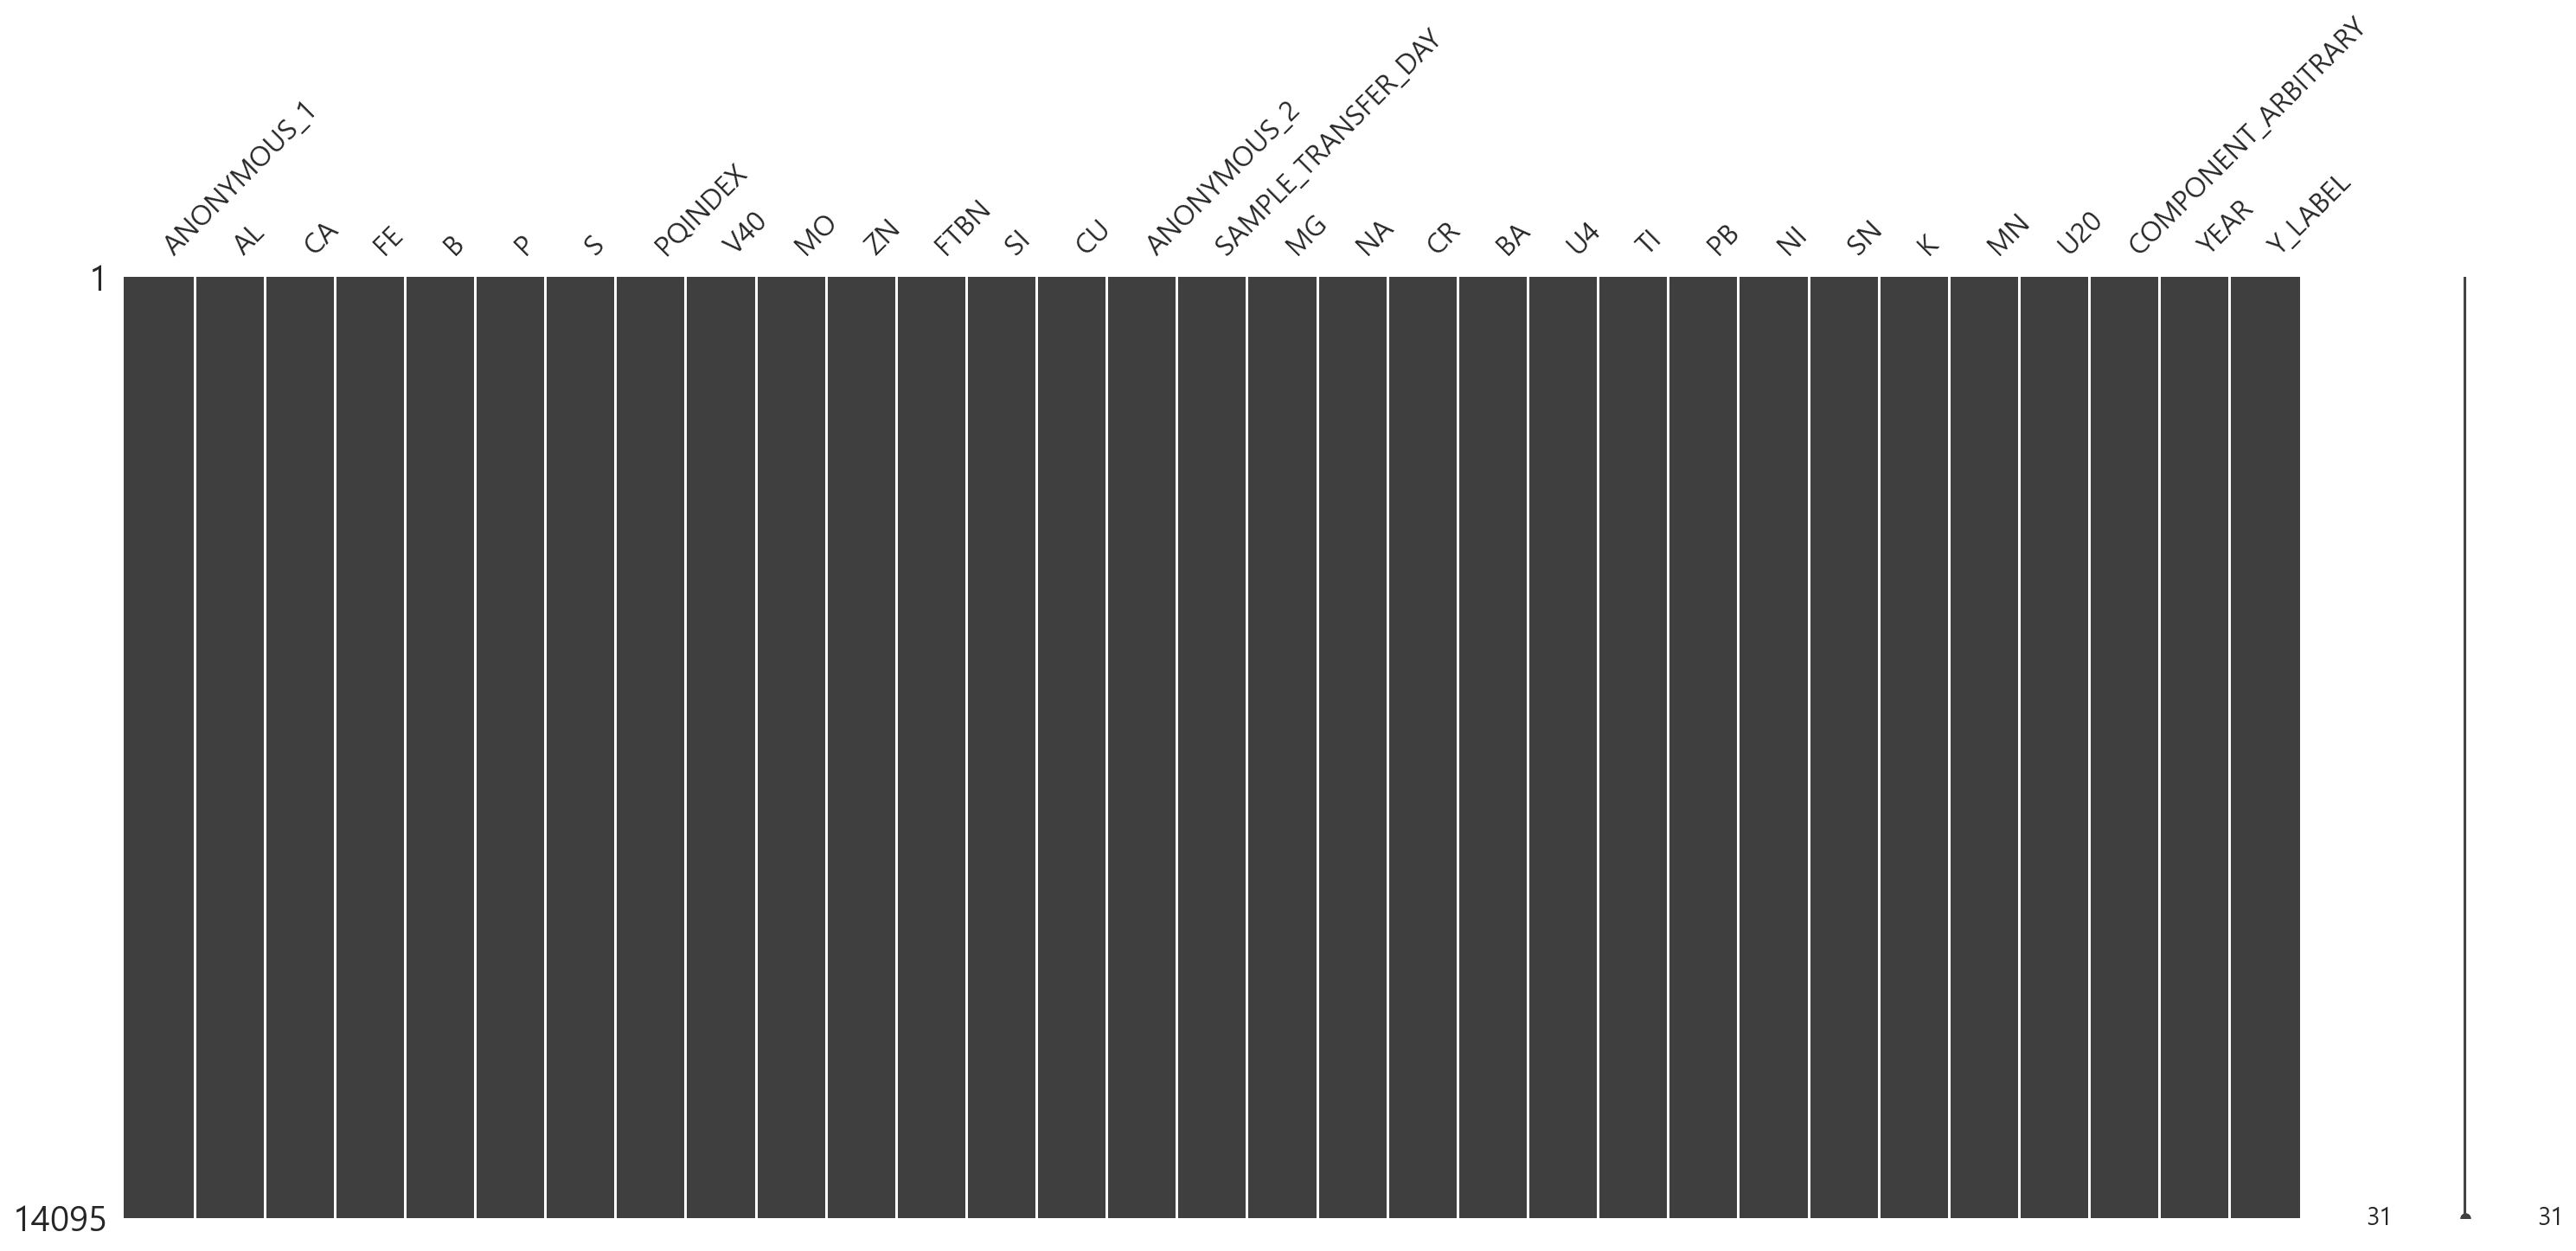

In [41]:
msno.matrix(data)

# 데이터 스케일링

In [42]:
# data.columns

In [43]:
categorical_features = ['COMPONENT_ARBITRARY', 'YEAR']

In [44]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in categorical_features:    
    data[col] = le.fit_transform(data[col])

In [45]:
data

,ANONYMOUS_1,AL,CA,FE,B,P,S,PQINDEX,V40,MO,...,TI,PB,NI,SN,K,MN,U20,COMPONENT_ARBITRARY,YEAR,Y_LABEL
0,1486,3,3059,888,93,1951,21370,8504,154.0,1,...,5,0,6,2,27.0,16,0.0,2,4,0
1,1350,2,2978,2,19,572,1117,19,44.0,0,...,0,2,0,0,0.0,0,4.0,1,14,0
2,2415,110,17,4,1,328,1334,17,72.6,0,...,0,0,0,1,0.0,0,3.0,1,8,1
3,7389,8,1960,37,3,906,21774,44,133.3,0,...,0,1,0,1,0.0,1,0.0,2,3,0
4,3954,1,71,71,157,309,18470,217,133.1,0,...,0,0,0,0,0.0,0,0.0,2,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,1616,2,6,23,201,477,22000,35,135.4,0,...,0,0,0,0,1.0,0,0.0,2,7,0
14091,2784,3,2945,12,85,1163,5494,9,117.5,224,...,0,1,0,0,4.0,0,0.0,0,6,0
14092,1788,6,13,415,0,1175,9640,645,54.0,10,...,0,1,1,0,0.0,7,0.0,2,1,0
14093,2498,2,2244,19,4,441,1313,11,44.3,1,...,0,1,0,0,0.0,0,8.0,1,2,0


# 컬럼제거 바로가기

In [46]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

ss = StandardScaler()
scaled = ss.fit_transform(data.drop(['COMPONENT_ARBITRARY', 'YEAR', 'Y_LABEL'], axis = 1))
columns = data.drop(['COMPONENT_ARBITRARY', 'YEAR', 'Y_LABEL'], axis = 1).columns

scaled = pd.DataFrame(scaled, columns = columns)
# scaled.head()

## log

In [ ]:
# for i in range(len(data2.columns)):
#     data2.iloc[:, i] = np.log1p(data2.iloc[:, i])

In [ ]:
# data2.hist(bins=80, figsize=(20,20))
# plt.show()

In [47]:
onehot = data[['COMPONENT_ARBITRARY', 'YEAR']]
scaled = pd.concat([onehot, scaled], axis = 1)
scaled

,COMPONENT_ARBITRARY,YEAR,ANONYMOUS_1,AL,CA,FE,B,P,S,PQINDEX,...,CR,BA,U4,TI,PB,NI,SN,K,MN,U20
0,2,4,-0.393763,-0.111628,1.141962,1.331290,0.281646,1.845136,1.001652,5.293270,...,0.339245,-0.238453,-0.171264,0.622282,-0.160812,1.384414,0.302478,1.669706,1.186914,-0.118804
1,1,14,-0.426022,-0.123127,1.087302,-0.330406,-0.437686,-0.598302,-1.170187,-0.259244,...,-0.115388,-0.238453,-0.085911,-0.102635,0.033010,-0.191804,-0.252439,-0.210453,-0.250456,-0.067218
2,1,8,-0.173409,1.118753,-0.910846,-0.326655,-0.612659,-1.030643,-1.146917,-0.260552,...,-0.080416,0.105735,2.240286,-0.102635,-0.160812,-0.191804,0.025019,-0.210453,-0.250456,-0.080114
3,2,3,1.006399,-0.054133,0.400333,-0.264764,-0.593217,-0.006490,1.044975,-0.242884,...,-0.115388,-0.238453,-0.171264,-0.102635,-0.063901,-0.191804,0.025019,-0.210453,-0.160621,-0.118804
4,2,8,0.191634,-0.134626,-0.874406,-0.200996,0.903771,-1.064309,0.690669,-0.129674,...,-0.115388,-0.238453,-0.171264,-0.102635,-0.160812,-0.191804,-0.252439,-0.210453,-0.250456,-0.118804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,2,7,-0.362928,-0.123127,-0.918269,-0.291021,1.331482,-0.766631,1.069210,-0.248773,...,-0.115388,0.105735,-0.171264,-0.102635,-0.160812,-0.191804,-0.252439,-0.140817,-0.250456,-0.118804
14091,0,6,-0.085884,-0.111628,1.065033,-0.311651,0.203880,0.448886,-0.700817,-0.265787,...,-0.115388,-0.238453,-0.171264,-0.102635,-0.063901,-0.191804,-0.252439,0.068089,-0.250456,-0.118804
14092,2,1,-0.322130,-0.077131,-0.913545,0.444177,-0.622379,0.470148,-0.256220,0.150406,...,0.024499,0.105735,-0.171264,-0.102635,-0.063901,0.070899,-0.252439,-0.210453,0.378393,-0.118804
14093,1,2,-0.153722,-0.123127,0.591983,-0.298523,-0.583497,-0.830419,-1.149169,-0.264479,...,-0.115388,-0.238453,0.937623,-0.102635,-0.063901,-0.191804,-0.252439,-0.210453,-0.250456,-0.015631


In [48]:
# plt.figure(figsize = (28, 28))
# sns.heatmap(scaled.corr(), annot = True, fmt = '0.1f', cmap = 'Blues')

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled, data['Y_LABEL'], test_size = 0.2, random_state = 2022, stratify = data['Y_LABEL'])

In [50]:
# from imblearn.under_sampling import NearMiss

# nearmiss=NearMiss()
# under_X,under_y = nearmiss.fit_resample(X_train, y_train)
# print("NearMiss 적용 전 학습용 피처/레이블 데이터 세트 : ", X_train.shape, y_train.shape)
# print('NearMiss 적용 후 학습용 피처/레이블 데이터 세트 :', under_X.shape, under_y.shape)
# print('NearMiss 적용 후 값의 분포 :\n',pd.Series(under_y).value_counts())

In [51]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print("SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ", X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 값의 분포 :\n',pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (11276, 30) (11276,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : (20628, 30) (20628,)
SMOTE 적용 후 값의 분포 :
 0    10314
1    10314
Name: Y_LABEL, dtype: int64


# 분류

## hyperopt

In [52]:
#!pip install hyperopt

In [53]:
from hyperopt import hp

In [54]:
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도 : {:.4f}, 정밀도 : {:.4f}, 재현율 : {:.4f}, F1 : {:.4f}, AUC : {:.4f}'.
          format(accuracy, precision, recall, f1, roc_auc))
    print('Macro f1 socre : ', f1_score(y_test, pred, average='macro'))


def get_model_train_eval(model, ftr_train = None, ftr_test = None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size = 0.1, stratify=y_train, random_state=2022)

lgbm_search_space = {
    'num_leaves':hp.quniform('num_leaves', 31, 64, 1),
    'max_depth':hp.quniform('max_depth', 1, 169, 1),                  ## 정수형 하이퍼 파라미터 => quniform 사용
    'min_child_weight':hp.quniform('min_child_weight', 60, 100, 1),     ## 정수형 하이퍼 파라미터 => quniform 사용
    'learning_rate':hp.uniform('learning_rate', 0.01, 1.0),
    'subsample':hp.uniform('subsample', 0.7, 1),
}

In [ ]:
from sklearn.model_selection import cross_val_score
from hyperopt import STATUS_OK
from sklearn.model_selection import KFold

def objective_func(search_space):

    lgbm_clf = LGBMClassifier(
    n_estimators=100,
    max_depth=int(search_space['max_depth']),                ## int형으로 형변환 필요
    min_child_weight=int(search_space['min_child_weight']),  ## int형으로 형변환 필요
    learning_rate=search_space['learning_rate'], 
    subsample=search_space['subsample'],
    num_leaves=int(search_space['num_leaves']),
      #eval_metric='logloss' => 불균형 데이터셋이므로 성능 평가 지표를 roc-auc로 설정
            )

      ## XGBoost와 LightGBM에서는 cross_val_score()를 적용하면 early stopping 지원 불가, KFold 방식으로 직접 구현해야 함
      ## 3개의 k-fold 방식으로 평가된 roc-auc 지표를 담는 list
    roc_auc_list = []

  ## 3개의 k-fold 방식 적용
    kf = KFold(n_splits=3)

    for tr_index, val_index in kf.split(X_train):

        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

        lgbm_clf.fit(
            X_tr, y_tr,
            early_stopping_rounds=30,
            eval_metric='auc',
            eval_set=[(X_tr, y_tr), (X_val, y_val)]
    )

        score = roc_auc_score(
            y_val,
            lgbm_clf.predict_proba(X_val)[:, 1]
    )

        roc_auc_list.append(score)

    return (-1) * np.mean(roc_auc_list)


In [ ]:
## 3) fmin()을 사용하여 최적 하이퍼 파라미터 찾기

from hyperopt import fmin, tpe, Trials

trials = Trials()

best = fmin(
    fn=objective_func,
    space=lgbm_search_space,
    algo=tpe.suggest,
    max_evals=30,  ## 30번 만큼 반복하며 최적의 하이퍼 파라미터 찾음
    trials=trials,
)

best

In [ ]:
## 획득한 최적의 하이퍼 파라미터를 이용하여 모델 선언
lgbm_wrapper = LGBMClassifier(
    n_estimators=500,
    num_leaves=int(best['num_leaves']),
    learning_rate=round(best['learning_rate'], 5),
    max_depth=int(best['max_depth']),
    min_child_weight=int(best['min_child_weight']),
    subsample=round(best['subsample'], 5)
)

In [ ]:
lgbm_wrapper.fit(
    X_tr, y_tr,
    early_stopping_rounds=100,
    eval_metric='logloss', #auc
    verbose=True,
    eval_set=[(X_tr, y_tr), (X_val, y_val)]
)

In [ ]:
lgbm_roc_score = roc_auc_score(
    y_val,
    lgbm_wrapper.predict_proba(X_val)[:, 1]
)

print(lgbm_roc_score)

preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, preds, pred_proba)


In [ ]:
# a = lgbm_wrapper.predict(X_test)
# b = lgbm_wrapper.predict_proba(X_test)[:, 1]
# get_clf_eval(y_test, a, b)

In [ ]:
# print(lgbm_wrapper.score(X_train_over, y_train_over))
# print(lgbm_wrapper.score(X_test, y_test))

# print(lgbm_wrapper.score(X_tr, y_tr))
# print(lgbm_wrapper.score(X_val, y_val))

## 로지스틱

In [ ]:
from sklearn.linear_model import LogisticRegression
from scipy.special import expit

#train_test_split data
lr = LogisticRegression()
lr.fit(X_train, y_train)

In [ ]:
params={'penalty':['l2'],
        'C':[1, 2, 3, 4, 5, 10]}

grid_clf = GridSearchCV(lr, param_grid = params, scoring='f1_macro', cv=10 )
grid_clf.fit(X_train, y_train)

grid_clf_pred = grid_clf.predict(X_test)


pred_X = grid_clf.predict(X_train)
pred_Y = grid_clf.predict(X_test)

print('train accuracy score :', accuracy_score(y_train, pred_X))
print('test accuracy score :', accuracy_score(y_test, pred_Y))
print('Macro f1 socre : ', f1_score(y_test, pred_Y, average='macro'))

print('\n최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_, grid_clf.best_score_))

In [ ]:
#   기울기     와     절편
# print(lr.coef_, lr.intercept_)

In [ ]:
# # z값 계산
# decisions = lr.decision_function(X_test)
# decisions

In [ ]:
# from scipy.special import expit

# print(expit(decisions))
# print(1 - expit(decisions))

In [ ]:
# def sigmoid(x):
#     return 1 / (1+np.exp(-x))

# train = np.arange(-12, 12, 0.1)
# result = sigmoid(train)

# plt.plot(train, result)
# plt.scatter(decisions, expit(decisions),marker='^' ,color = 'g', s=60)
# plt.scatter(0, 0.5, marker = 'D', color = 'black')

# plt.title('시그모이드 시각화')
# plt.xlabel('Z값')
# plt.ylabel('시그모이드값')
# plt.ylim(-0.1, 1.1)
# plt.show()

## RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

In [ ]:
rf = RandomForestClassifier(n_jobs=-1, random_state = 2022)
#rf.fit(X_train, y_train)

params = {
    'n_estimators':[5, 6, None],
    'max_depth':[7, 8, 9],
    'min_samples_leaf':[2, 3],
    'min_samples_split':[5, 6, 7]
}
#                                                     돌림
rf_gs = GridSearchCV(rf, param_grid = params, cv = 5, refit = True, n_jobs=-1)
rf_gs.fit(X_train, y_train)

In [ ]:
print(rf_gs.best_params_)

In [ ]:
rf_pred = rf_gs.predict(X_test)

pred_X = rf_gs.predict(X_train)
pred_Y = rf_gs.predict(X_test)

print('train accuracy score :', accuracy_score(y_train, pred_X))
print('test accuracy score :', accuracy_score(y_test, pred_Y))
print('Macro f1 socre : ', f1_score(y_test, rf_pred, average='macro'))

### 최저 파라미타

In [ ]:
rf_end = RandomForestClassifier(max_depth = 6, 
                                min_samples_leaf=2, min_samples_split = 5, 
                                n_estimators = 6)
rf_end.fit(X_train, y_train)
rf_endd = cross_val_predict(rf_end, X_test, y_test)

In [ ]:
pred_X = rf_end.predict(X_train)
pred_Y = rf_end.predict(X_test)

print('train accuracy score :', accuracy_score(y_train, pred_X))
print('test accuracy score :', accuracy_score(y_test, pred_Y))
print('Macro f1 socre : ', f1_score(y_test, rf_endd, average='macro'))

## Xgboost

#### Step 1

In [ ]:
# 방법 1
import xgboost as xgb

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=2022)
# 90%  10%


dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test, label=y_test)


params = {'max_depth': 9,  # 트기 최대 깊이 (3~10)
          'eta': 0.05,     # 학습률 XGBClassifier인경우 learning_rate 사용해야함
          'objective' : 'binary:logistic', # 0, 1 이진 분류이므로 목적함수(objective)는 이진 로지스틱(vinary:logistic)
          'eval_metric' : 'logloss'}  # 회귀

num_rounds = 300

eval_list = [(dtr,'train'),(dval,'eval')]


#                                        훈련             반복회수                    조기 중단:(최소50부터)    
xgb_model = xgb.train(params = params, dtrain=dtr, num_boost_round = num_rounds, early_stopping_rounds=150, evals=eval_list)  
xgb_pred = xgb_model.predict(dtest)

#xgb_pred_corss = xgb_model.predict(dtest)


preds = [1 if x >= 0.5 else 0 for x in xgb_pred]
print('예측값 10개만 표시 : ', preds[:0])

In [ ]:
print('Macro f1 socre : ', f1_score(y_test, preds, average='macro'))
print('Micro f1 socre : ', f1_score(y_test, preds, average='micro'))

#### Step 2

In [ ]:
from xgboost import XGBClassifier 

model = XGBClassifier(random_state=1)

parameters={'max_depth': [2,3,4],
            'n_estimators': [500],
            'learning_rate': [0.1, 0.2, 0.5]}

grid_search = GridSearchCV(model, parameters, scoring='f1_macro', cv=5, n_jobs=-1) 
grid_search.fit(X_train, y_train) 
grid_search.best_params_

print('교차건증：\n', grid_search.best_score_)
print('최우선 점수 ：\n', grid_search.best_params_)

In [ ]:
gs_XGB_pred = grid_search.predict(X_test)

In [ ]:
min_XGB = XGBClassifier(random_state=2022, learning_rate= 0.2, max_depth=2, n_estimators = 500)

min_XGB.fit(X_train, y_train) 
min_xgb_pred = min_XGB.predict(X_test)

In [ ]:
pred_X = min_XGB.predict(X_train)
pred_Y = min_XGB.predict(X_test)

print('train accuracy score :', accuracy_score(y_train, pred_X))
print('test accuracy score :', accuracy_score(y_test, pred_Y))
print('Macro f1 socre : ', f1_score(y_test, min_xgb_pred, average='macro'))
print('Micro f1 socre : ', f1_score(y_test, min_xgb_pred, average='micro'))

In [ ]:
pred = min_XGB.predict(X_test)
pred_proba = min_XGB.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, pred, pred_proba)

In [ ]:
#feature 중요도도 그려볼 수 있다. 
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(12, 15))

# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(min_XGB, ax=ax)
plt.rc('font', size=20)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize = 30)
plt.show()

In [ ]:
precision_recall_curve_plot(y_test, pred_proba)

In [ ]:
binarizer = Binarizer(threshold = 0.2)
thres_pred = binarizer.fit_transform(pred_proba.reshape(-1,1))

get_clf_eval(y_test, thres_pred, pred_proba.reshape(-1,1))

print('Micro f1 socre : ', f1_score(y_test, thres_pred, average='micro'))

#### step 3

In [ ]:
from xgboost import XGBClassifier 

model = XGBClassifier(random_state=2022, subsample=0.9)

parameters={'max_depth':        [1,2,3,4,5],
            'n_estimators':     [500],
            'learning_rate':    [0.2, 0.5, 0.8],
            'eta':              [0.01, 0.02],
            'min_split_loss':   [2],
            'scale_pos_weight': [1, 3, 5],
            'gamma':            [0, 0.25, 1.0],
           }

grid_search = GridSearchCV(model, parameters, scoring='f1_macro', cv=3, n_jobs=-1) 
grid_search.fit(X_train, y_train) 
grid_search.best_params_

print('교차건증 交叉验证：\n', grid_search.best_score_)
print('최우선 점수 最优选项：\n', grid_search.best_params_)

In [ ]:
min_XGB = XGBClassifier(random_state=2022,
                        eta = 0.01,
                        gamma = 0,
                        learning_rate= 0.2, 
                        max_depth = 4, 
                        min_split_loss = 2,
                        n_estimators = 500,
                        scale_pos_weight = 1)
                        
                        
min_XGB.fit(X_train, y_train) 
min_xgb_pred = min_XGB.predict(X_test)

In [ ]:
pred_X = min_XGB.predict(X_train)
pred_Y = min_XGB.predict(X_test)

print('train accuracy score :', accuracy_score(y_train, pred_X))
print('test accuracy score :', accuracy_score(y_test, pred_Y))
print('Macro f1 socre : ', f1_score(y_test, min_xgb_pred, average='macro'))

In [ ]:
pred = min_XGB.predict(X_test)
pred_proba = min_XGB.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, pred, pred_proba)

## LightGBM

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
evals = [(X_test, y_test)]

lgbm = LGBMClassifier(n_estimators = 2022) # 4천번 
lgbm.fit(X_train, y_train, early_stopping_rounds = 100, #100번 돌림
         eval_metric='logloss', eval_set=evals, verbose=True)

lgbm_pred = lgbm.predict(X_test)


parameters={'max_depth': [1,2,3,4,5],
            'n_estimators': [500],
            'learning_rate': [0.2, 0.5, 0.8]}

grid_search = GridSearchCV(model, parameters, scoring='f1_macro', cv=5, n_jobs=-1) 
grid_search.fit(X_train, y_train) 
grid_search.best_params_

print('교차건증：\n', grid_search.best_score_)
print('최우선 점수 ：\n', grid_search.best_params_)

In [ ]:
pred_X = lgbm.predict(X_train)
pred_Y = lgbm.predict(X_test)
pred_proba_Y = lgbm.predict_proba(X_test)[:, 1]

print('train accuracy score :', accuracy_score(y_train, pred_X))
print('test accuracy score :', accuracy_score(y_test, pred_Y))
print('Micro f1 socre : ', f1_score(y_test, lgbm_pred, average='macro'))
print()
#print(lgbm.score(y_test, pred_Y))


In [ ]:
get_clf_eval(y_test, pred_Y, pred_proba_Y)

In [ ]:
precision_recall_curve_plot(y_test, pred_proba)

In [ ]:
for i in np.arange(0, 1, 0.01):
    binarizer = Binarizer(threshold = i)
    thres_pred = binarizer.fit_transform(pred_proba.reshape(-1,1))

    get_clf_eval(y_test, thres_pred, pred_proba.reshape(-1,1))
    print('Macro f1 socre : ', f1_score(y_test, thres_pred, average='macro'))

In [ ]:
# # 튜닝
# parameters = {'num_leaves':[20,40,60,80,100], 'min_child_samples':[5,10,15],'max_depth':[-1,5,10,20],
#              'learning_rate':[0.05,0.1,0.2],'reg_alpha':[0,0.01,0.03]} #Define the scoring


# clf = GridSearchCV(lgbm, parameters, scoring='accuracy', cv = 5)
# clf.fit(X_train_over, y_train_over)

# lgbm_pred = clf.predict(X_test)

In [ ]:
# print(clf.score(X_train_over, y_train_over))
# print(clf.score(X_test, y_test))
# print('Macro f1 socre : ', f1_score(y_test, lgbm_pred, average='macro'))

## 의사결정 트리

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state = 2022)
dtree.fit(X_train_over, y_train_over)

In [ ]:
tree_model = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 6, random_state = 2022)
tree_model.fit(X_train, y_train)

tree_pred = tree_model.predict(X_test)

pred_X = tree_model.predict(X_train)
pred_Y = tree_model.predict(X_test)

print('train accuracy score :', accuracy_score(y_train, pred_X))
print('test accuracy score :', accuracy_score(y_test, pred_Y))
print('Macro f1 socre : ', f1_score(y_test, tree_pred, average='macro'))

## GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

tree_model = DecisionTreeClassifier(random_state = 2022)

params = {
    'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, None],
    'min_samples_leaf':[9, 10, 11, 12, 13],
    'min_samples_split':[2, 3, 4, 5]
}
#                                                      #돌림        코어제어(시스템모든 코어 사용함) : 이유 느리기때문에
tree_gs = GridSearchCV(tree_model, param_grid = params, cv = 5, refit = True, n_jobs=-1)
tree_gs.fit(X_train, y_train)

In [ ]:
tree_gs_num = tree_gs.best_params_
tree_gs_num

In [ ]:
tree_gsCV_pree = tree_gs.predict(X_test)

In [ ]:
print('Macro f1 socre : ', f1_score(y_test, tree_gsCV_pree, average='macro'))

In [ ]:
tree_model = DecisionTreeClassifier(max_depth = 3, min_samples_leaf =9, min_samples_split= 2, random_state = 2022)
tree_model.fit(X_train, y_train)
tree_gsCV_pred = tree_model.predict(X_test)

pred_X = tree_model.predict(X_train)
pred_Y = tree_model.predict(X_test)

print('train accuracy score :', accuracy_score(y_train, pred_X))
print('test accuracy score :', accuracy_score(y_test, pred_Y))
print('Macro f1 socre : ', f1_score(y_test, tree_gsCV_pred, average='macro'))

## Voting

In [ ]:
# 부팅 분류기 Voting
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

f1_list = []

#
lg = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors = 2)


voting_model = VotingClassifier(estimators = [('lg', lg), ('knn',knn)], voting = 'soft')

voting_model.fit(X_train, y_train)
pred = voting_model.predict(X_test)


#각 모델 에측과 평가
models = [lg, knn]
for model in models :
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    model_name = model.__class__.__name__
    
    pred_X = model.predict(X_train)
    pred_Y = model.predict(X_test)

    print('train accuracy score :', accuracy_score(y_train, pred_X))
    print('test accuracy score :', accuracy_score(y_test, pred_Y))
    print('Macro f1 socre : ', f1_score(y_test, pred, average='macro'))
    print()

# 딥러닝 : 분류

## 경사하강법

In [ ]:
from sklearn.linear_model import SGDClassifier 

In [ ]:
sc = SGDClassifier(loss = 'log', max_iter=25, tol = None, random_state=2022) # 이진분류
sc.fit(X_train, y_train)

In [ ]:
print(sc.score(X_train, y_train))
print(sc.score(X_test, y_test))

In [ ]:
sc.partial_fit(X_train, y_train)
print(sc.score(X_train, y_train))
print(sc.score(X_test, y_test))

In [ ]:
# sc.predict(y_test)

In [ ]:
params = {
    'max_iter':[20, 30]
}

sc_gs = GridSearchCV(sc, param_grid = params, cv = 5, refit = True, n_jobs=-1, )
sc_gs.fit(X_train, y_train)

In [ ]:
#y_test_np = y_test.to_numpy()
#y_test_np.reshape(-1, 1)
# sc_gs.predict(y_test)

### 애포크 찾기

In [ ]:
sc = SGDClassifier(loss = 'log', random_state=2022)

train_score = []
test_score = []


classes = np.unique(y_train)


for _ in range(0, 50) :
    sc.partial_fit(X_train, y_train, classes = classes)
    train_score.append(sc.score(X_train, y_train))
    test_score.append(sc.score(X_test, y_test))
    
plt.plot(train_score)
plt.plot(test_score)
plt.xlabel('epoch')
plt.ylabel('accuacy')
plt.xlim(0, 50)
plt.show()

## PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
X_train.shape

In [ ]:
pca = PCA(n_components = 0.95, whiten = True)
pca_data = pca.fit_transform(X_train)
pca_data.shape

In [ ]:
# pca_data = pd.DataFrame(pca_data, columns = ['pca_x','pca_y'])

In [ ]:
# 변동성
pca.explained_variance_ratio_.sum()

## K-means

In [ ]:
from sklearn.cluster import KMeans 

In [ ]:
# target_t = target_t.to_numpy()

In [ ]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=25, random_state=2022)
kmeans.fit(X_train)
cluster = kmeans.predict(X_test)

In [ ]:
print(kmeans.score(X_train, y_train))
print(kmeans.score(X_test, y_test))
print('Macro f1 socre : ', f1_score(y_test, cluster, average='macro'))

In [ ]:
k_means_df = pd.DataFrame()
k_means_df['target'] = y_test
k_means_df['cluster'] = cluster

In [ ]:
k_means_df

In [ ]:
#pca_sample_df = pd.concat([pca_data,k_means_df], axis=1)
#center = kmeans.cluster_centers_

In [ ]:
# center

In [ ]:
# plt.scatter(pca_sample_df['pca_x'], pca_sample_df['pca_y'], c=pca_sample_df['cluster'], cmap='YlGnBu')
# plt.scatter(center[:,0], center[:, 1], c='red', marker='D')
# plt.ylim(0, 20)
# plt.show()

In [ ]:
# from sklearn.cluster import DBSCAN # 引入DBSCAN模块
# dbscan = DBSCAN(eps=0.05, min_samples=9).fit(X_train)
# label_pred = dbscan.labels_ 
# pd.DataFrame(label_pred).value_counts()

In [ ]:

# y_pred=DBSCAN(eps=0.05,min_samples=10).fit_predict(X_test)
# plt.subplot(122)
# plt.scatter(X_test[:, 0], X_test[:, 1],c=y_pred)
# plt.title('DBSCAN Cluster Result')
# if flag:
#     plt.savefig('circleData.png')
# else:
#     plt.savefig('blobData.png')


## DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X_train)

df = pd.DataFrame()

df['dbscan_cluster'] = dbscan_labels
df['target'] = y_train

df_result = df.groupby(['target'])['dbscan_cluster'].value_counts()
print(df_result)

In [ ]:
### 클러스터 결과를 담은 DataFrame과 사이킷런의 Cluster 객체등을 인자로 받아 클러스터링 결과를 시각화하는 함수  
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

In [ ]:
from sklearn.decomposition import PCA


# 2차원으로 시각화하기 위해 PCA n_componets=2로 피처 데이터 세트 변환
pca = PCA(n_components=2, random_state=2022)
pca_transformed = pca.fit_transform(X_train)


# visualize_cluster_2d( ) 함수는 ftr1, ftr2 컬럼을 좌표에 표현하므로 PCA 변환값을 해당 컬럼으로 생성
df['ftr1'] = pca_transformed[:, 0]
df['ftr2'] = pca_transformed[:, 1]

# visualize_cluster_plot(dbscan, df, 'dbscan_cluster', iscenter=False)

In [ ]:
# visualize_cluster_plot(dbscan, df, 'dbscan_cluster', iscenter=False)

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X_train)

df['dbscan_cluster'] = dbscan_labels
df['target'] = y_train

df_result = df.groupby(['target'])['dbscan_cluster'].value_counts()
print(df_result)

#visualize_cluster_plot(dbscan, df, 'dbscan_cluster', iscenter=False)

In [ ]:
dbscan = DBSCAN(eps=0.6, min_samples=16, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X_train)

df['dbscan_cluster'] = dbscan_labels
df['target'] = y_train

df_result = df.groupby(['target'])['dbscan_cluster'].value_counts()
print(df_result)
visualize_cluster_plot(dbscan, df, 'dbscan_cluster', iscenter=False)

In [ ]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, shuffle=True, noise=0.05, random_state=2022, factor=0.5)
clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

In [ ]:
# KMeans로 make_circles( ) 데이터 셋을 클러스터링 수행. 
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, max_iter=1000, random_state=0)
kmeans_labels = kmeans.fit_predict(X)
clusterDF['kmeans_cluster'] = kmeans_labels

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_cluster', iscenter=True)

In [ ]:
# GMM으로 make_circles( ) 데이터 셋을 클러스터링 수행. 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=0)
gmm_label = gmm.fit(X).predict(X)
clusterDF['gmm_cluster'] = gmm_label

visualize_cluster_plot(gmm, clusterDF, 'gmm_cluster', iscenter=False)

get_f1_score(y, gmm_label)

In [ ]:
# DBSCAN으로 make_circles( ) 데이터 셋을 클러스터링 수행. 
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=10, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X)
clusterDF['dbscan_cluster'] = dbscan_labels

visualize_cluster_plot(dbscan, clusterDF, 'dbscan_cluster', iscenter=False)
get_f1_score(y, dbscan_labels)

## Staking Model

### 데이터 Numpy로 세팅

In [ ]:
nX_train = X_train.to_numpy()
nX_test = X_test.to_numpy()

### 개별 모델 생성

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=2022)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

lr_final = LogisticRegression()

### 모델 개별 학습

In [ ]:
knn_clf.fit(nX_train, y_train)
rf_clf.fit(nX_train, y_train)
dt_clf.fit(nX_train, y_train)
ada_clf.fit(nX_train, y_train)

# knn_clf.fit(X_train_voer, y_train_over)
# rf_clf.fit(X_train_voer, y_train_over)
# dt_clf.fit(X_train_voer, y_train_over)
# aba_clf.fit(X_train_voer, y_train_over)

### 개별 모델 예측

In [ ]:
# 삭습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정

knn_pred = knn_clf.predict(nX_test)
rf_pred = rf_clf.predict(nX_test)
dt_pred = dt_clf.predict(nX_test)
ada_pred = ada_clf.predict(nX_test)
#gbm_pred = gbm_clf.predict(X_test)

### 개별 모델 정확도 확인

In [ ]:
print('Knn 정확도 : %.4f' %(accuracy_score(y_test, knn_pred)))
print('RandomForst 정확도 : %.4f' %(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도 : %.4f' %(accuracy_score(y_test, dt_pred)))
print('ada부스트 정확도 : %.4f' %(accuracy_score(y_test, ada_pred)))
print()

models = [knn_pred , rf_pred, dt_pred, ada_pred]
name = ['knn', 'RandomForst', '결정 트리', 'ada부스트']


for i in range(len(name)):
    get_f1(name[i], y_test, models[i])

### 로지스틱 - 예측값을 피처값으로, 로지스틱 회귀에 재사용

In [ ]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측결과를 피처로 만듦
pred = np.transpose(pred)
print(pred.shape)

In [ ]:
pred

### LogisticRegression

In [ ]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 이측 정확도 : %.4f' %(accuracy_score(y_test, final)))
get_f1('LogisticRegression', y_test, final)

In [ ]:
print(X_train.shape)
print(y_train.shape)

In [ ]:
nX_train

### 스텝 1

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 메타 모델을 위한 학습 및 테스트 데이터 만들기
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=False)
    # 빈 배열 생성
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('폴드 세트 : ', folder_counter, ' 시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index] 
        
        # 폴드 내 모델 학습
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1) # y_train 예측, 폴드 끝나면 concat해야함
        test_pred[:, folder_counter] = model.predict(X_test_n) # y_test 예측, 폴드 끝나면 평균 낼거임
        
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    return train_fold_pred, test_pred_mean # 하나의 모델에 대한 학습데이터, 테스트 데이터 생성

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression # 메타 모델

X_train_n = X_train.reset_index(drop=True).values
X_test_n = X_test.reset_index(drop=True).values
y_train_n = y_train.reset_index(drop=True).values

knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train_n, y_train_n, X_test_n, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train_n, y_train_n, X_test_n, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train_n, y_train_n, X_test_n,  7)    
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train_n, y_train_n, X_test_n, 7)

### 스텝 2

In [ ]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

In [ ]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))



In [ ]:
print('Macro f1 socre : ', f1_score(y_test, stack_final, average='macro'))
print('Micro f1 socre : ', f1_score(y_test, stack_final, average='micro'))

# End Test

In [ ]:
sub = pd.read_csv('sample_submission.csv')
sub['Y_LABEL'] = pred
sub.head(3)

In [ ]:
sub.to_csv('sample_submission.csv', index=False)